The core of this project is based around a simple task -- performing genre analysis on the “Multi-
Lingual Lyrics for Genre Classification” dataset on kaggle.
https://www.kaggle.com/datasets/mateibejan/multilingual-lyrics-for-genre-classification
This is an extensive dataset that is split into training and testing subsets. The testing dataset
should be used for final testing only. The training dataset should be all training and validation
tasks as appropriate.
This first part of the task is to perform a number of analyses based on training from scratch to
predict genre based on initially on song lyrics and then on song lyrics and artist.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN, Dropout, Input, Reshape, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout, Flatten
from IPython.display import Image
import tensorflow_hub as hub


# Download necessary NLTK data files
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')


# List physical devices to see if a GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johan.pieterse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/johan.pieterse/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/johan.pieterse/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/johan.pieterse/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [33]:
# Define the paths to the train and test CSV files
train_file_path = 'part_1_data/train_encoded_lemmatize.csv'
test_file_path = 'part_1_data/test_encoded_lemmatize.csv'

# Load the train and test datasets
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Convert all entries in the DataFrames to strings
train_df = train_df.astype(str)
test_df = test_df.astype(str)

In [34]:
# Encode the labels
label_encoder = LabelEncoder()
train_df['genre'] = label_encoder.fit_transform(train_df['genre'])
test_df['genre'] = label_encoder.transform(test_df['genre'])

In [35]:
max_length = 1000
vocab_size = 10000
# Function to preprocess and optionally pad text data
def preprocess_text_data(train_df, test_df, max_artist_length=3, use_padding=True):
    global max_length
    global vocab_size
    # Split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(train_df['lyrics'], train_df['genre'], test_size=0.2, random_state=42)

    # Tokenize the text data
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(X_train)
    # vocab_size = len(tokenizer.word_index) + 1  # +1 because word_index starts from 1

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)
    X_test_seq = tokenizer.texts_to_sequences(test_df['lyrics'])

    # max_length = max([len(seq) for seq in X_train_seq])
    # print(f"Maximum sequence length: {max_length}")

    # Optionally Pad the sequences
    if use_padding:
        X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
        X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')
        X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')
    else:
        X_train_pad, X_val_pad, X_test_pad = X_train_seq, X_val_seq, X_test_seq

    # Prepare artist data
    artist_tokenizer = Tokenizer()
    artist_tokenizer.fit_on_texts(train_df['artist'])
    X_train_artist_seq = artist_tokenizer.texts_to_sequences(X_train)
    X_val_artist_seq = artist_tokenizer.texts_to_sequences(X_val)
    X_test_artist_seq = artist_tokenizer.texts_to_sequences(test_df['artist'])

    # Optionally Pad the artist sequences
    if use_padding:
        X_train_artist_pad = pad_sequences(X_train_artist_seq, maxlen=max_artist_length, padding='post')
        X_val_artist_pad = pad_sequences(X_val_artist_seq, maxlen=max_artist_length, padding='post')
        X_test_artist_pad = pad_sequences(X_test_artist_seq, maxlen=max_artist_length, padding='post')
    else:
        X_train_artist_pad, X_val_artist_pad, X_test_artist_pad = X_train_artist_seq, X_val_artist_seq, X_test_artist_seq

    return X_train_pad, X_val_pad, X_test_pad, X_train_artist_pad, X_val_artist_pad, X_test_artist_pad, y_train, y_val

# Example Usage
X_train_pad, X_val_pad, X_test_pad, X_train_artist_pad, X_val_artist_pad, X_test_artist_pad, y_train, y_val = preprocess_text_data(
    train_df, test_df, max_artist_length=3, use_padding=True
)


In [36]:
print(f"Maximum sequence length: {max_length}")
print(f"Vocabulary size: {vocab_size}")

Maximum sequence length: 1000
Vocabulary size: 10000


In [37]:
# Create the directory if it doesn't exist
os.makedirs('part_1', exist_ok=True)

print("Shape of input data:", X_train_pad.shape)


Shape of input data: (232118, 1000)


In [38]:
dropout_rate = 0.5
# Define the model architecture
def create_rnn_model(input_length, vocab_size, embedding_dim, state_size, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
    model.add(SimpleRNN(state_size, return_sequences=False, activation="tanh"))
    model.add(Dropout(dropout_rate))  # Dropout after the RNN layer
    model.add(Dense(num_classes, activation='softmax'))
    return model

def create_multi_layer_rnn_model(input_length, vocab_size, embedding_dim, state_size, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
    model.add(SimpleRNN(state_size, return_sequences=True))  # First RNN layer with return_sequences=True
    model.add(Dropout(dropout_rate))  # Add dropout
    model.add(SimpleRNN(state_size, return_sequences=True))  # Second RNN layer with return_sequences=True
    model.add(Dropout(dropout_rate))  # Add dropout
    model.add(SimpleRNN(state_size))  # Third RNN layer without return_sequences
    model.add(Dense(num_classes, activation='softmax'))
    return model

def create_lstm_model(input_length, vocab_size, embedding_dim, state_size, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
    model.add(LSTM(state_size, return_sequences=False, activation="tanh"))
    model.add(Dropout(dropout_rate))  # Add dropout
    model.add(Dense(num_classes, activation='softmax'))
    return model

def create_multi_layer_lstm_model(input_length, vocab_size, embedding_dim, state_size, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
    model.add(LSTM(state_size, return_sequences=True, activation="tanh"))
    model.add(Dropout(dropout_rate))  
    model.add(LSTM(state_size, return_sequences=True, activation="tanh"))
    model.add(Dropout(dropout_rate))  
    model.add(LSTM(state_size, return_sequences=False, activation="tanh"))
    model.add(Dropout(dropout_rate))  
    model.add(Dense(num_classes, activation='softmax'))    
    return model

def create_lstm_model_multi_label(max_length, vocab_size, embedding_dim, state_size, num_classes, artist_vocab_size):
    # Input layer for lyrics
    lyrics_input = Input(shape=(max_length,), name='lyrics_input')
    lyrics_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(lyrics_input)
    lyrics_lstm = LSTM(state_size, return_sequences=False)(lyrics_embedding)

    # Input layer for artist
    artist_input = Input(shape=(1,), name='artist_input')
    artist_embedding = Embedding(input_dim=artist_vocab_size, output_dim=embedding_dim, input_length=1)(artist_input)
    # artist_flat = Flatten()(artist_embedding)
    artist_lstm = LSTM(state_size, return_sequences=False)(artist_embedding)

    # Concatenate lyrics and artist representations
    concatenated = Concatenate()([lyrics_lstm, artist_lstm])
    dense = Dense(128, activation='relu')(concatenated)
    dropout = Dropout(dropout_rate)(dense)
    output = Dense(num_classes, activation='softmax')(dropout)

    # Create the model
    model = Model(inputs=[lyrics_input, artist_input], outputs=output)
    return model

In [ ]:
# Set hyperparameters
num_epochs = 10 # Define the number of epochs
embedding_dim = 100
state_size = 64  # Define the state size for both RNN and LSTM models
num_classes = len(label_encoder.classes_)
artist_vocab_size = len(train_df['artist'].unique())
learning_rate=1e-3


# Ensure the directory exists
output_dir = 'model_plots'
# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

log_dir = "logs"
tensorboard_callback = TensorBoard(log_dir=log_dir)

# Create and compile the RNN model
rnn_model = create_rnn_model(max_length, vocab_size, embedding_dim, state_size, num_classes)
rnn_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create and compile the Multi Layer RNN model
multi_layer_rnn_model = create_multi_layer_rnn_model(max_length, vocab_size, embedding_dim, state_size, num_classes)
multi_layer_rnn_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Create and compile the LSTM model
lstm_model = create_lstm_model(max_length, vocab_size, embedding_dim, state_size, num_classes)
lstm_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create and compile the Multi Layer LSTM model
multi_layer_lstm_model = create_multi_layer_lstm_model(max_length, vocab_size, embedding_dim, state_size, num_classes)
multi_layer_lstm_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Create and compile the LSTM model with multi label input
lstm_model_multi = create_lstm_model_multi_label(max_length, vocab_size, embedding_dim, state_size, num_classes, artist_vocab_size)
lstm_model_multi.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Compile the model
# lstm_model_pretrained = create_pretrained_lstm_model(state_size)
# lstm_model_pretrained.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

/Users/johan.pieterse/Library/CloudStorage/GoogleDrive-fizzerpieterse@gmail.com/My Drive/Akedemie/TU - Dublin/Deep Learning/Assignment/myenv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [41]:
# Initialize an empty list to store the results
results = []

In [42]:
# Train the RNN model
num_epochs = 15
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define the checkpoint callback dynamically using lambda to include the model name
checkpoint_path = f'part_1/best_rnn_model.keras'
checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
  

history_rnn = rnn_model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=num_epochs, batch_size=32, callbacks=[early_stopping, checkpoint, tensorboard_callback])
rnn_model.summary()

# Load the best model saved during training
best_model = load_model(f'part_1/best_rnn_model.keras')

# Evaluate the model on the test data (Block 1)
test_loss, test_acc = best_model.evaluate(X_test_pad, test_df['genre'])

# Store the results in the list
results.append({
    'model_name': 'best_rnn_model',
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'model_history': history_rnn
})


Epoch 1/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.3984 - loss: 1.4910
Epoch 1: val_loss improved from inf to 1.43095, saving model to part_1/best_rnn_model.keras
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 839s 116ms/step - accuracy: 0.3984 - loss: 1.4910 - val_accuracy: 0.4172 - val_loss: 1.4309
Epoch 2/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.4089 - loss: 1.4286
Epoch 2: val_loss did not improve from 1.43095
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 4157s 573ms/step - accuracy: 0.4089 - loss: 1.4286 - val_accuracy: 0.4171 - val_loss: 1.4348
Epoch 3/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.4079 - loss: 1.4340
Epoch 3: val_loss did not improve from 1.43095
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 865s 119ms/step - accuracy: 0.4079 - loss: 1.4340 - val_accuracy: 0.4171 - val_loss: 1.4352
Epoch 4/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.4096 - loss: 1.4277
Epoch 4: val_loss did not improve from 1.43095
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 2754s 

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 1000, 100)      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_12 (SimpleRNN)       │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,033,632 (11.57 MB)

 Trainable params: 1,011,210 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,022,422 (7.71 MB)

248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.1811 - loss: 3.1145


In [43]:
# Train the stacked RNN model
num_epochs = 15
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define the checkpoint callback dynamically using lambda to include the model name
checkpoint_path = f'part_1/best_multi_layer_rnn_model.keras'
checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

history_multi_layer_rnn = multi_layer_rnn_model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=num_epochs, batch_size=32, callbacks=[early_stopping, checkpoint, tensorboard_callback])
multi_layer_rnn_model.summary()


# Load the best model saved during training
best_model = load_model(f'part_1/best_multi_layer_rnn_model.keras')

# Evaluate the model on the test data (Block 1)
test_loss, test_acc = best_model.evaluate(X_test_pad, test_df['genre'])

# Store the results in the list
results.append({
    'model_name': 'best_multi_layer_rnn_model',
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'model_history': history_multi_layer_rnn
})


Epoch 1/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.4059 - loss: 1.4363
Epoch 1: val_loss improved from inf to 1.43087, saving model to part_1/best_multi_layer_rnn_model.keras
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 2678s 369ms/step - accuracy: 0.4059 - loss: 1.4363 - val_accuracy: 0.3735 - val_loss: 1.4309
Epoch 2/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.4069 - loss: 1.4260
Epoch 2: val_loss did not improve from 1.43087
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 2689s 371ms/step - accuracy: 0.4069 - loss: 1.4260 - val_accuracy: 0.4171 - val_loss: 1.4350
Epoch 3/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.4083 - loss: 1.4249
Epoch 3: val_loss did not improve from 1.43087
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 2575s 355ms/step - accuracy: 0.4083 - loss: 1.4249 - val_accuracy: 0.3735 - val_loss: 1.4424
Epoch 4/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.4078 - loss: 1.4258
Epoch 4: val_loss did not improve from 1.43087
7254/7254 ━━━━━━━━━━━━━

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 1000, 100)      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ (None, 1000, 64)       │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 1000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_14 (SimpleRNN)       │ (None, 1000, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_15 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,083,168 (11.76 MB)

 Trainable params: 1,027,722 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,055,446 (7.84 MB)

248/248 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.1364 - loss: 3.1714


In [44]:
# Train the LSTM model
num_epochs = 15
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define the checkpoint callback dynamically using lambda to include the model name
checkpoint_path = f'part_1/best_lstm_model.keras'
checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

history_lstm = lstm_model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=num_epochs, batch_size=32, callbacks=[early_stopping, checkpoint, tensorboard_callback])
lstm_model.summary()

# Load the best model saved during training
best_model = load_model(f'part_1/best_lstm_model.keras')

# Evaluate the model on the test data (Block 1)
test_loss, test_acc = best_model.evaluate(X_test_pad, test_df['genre'])

# Store the results in the list
results.append({
    'model_name': 'best_lstm_model',
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'model_history': history_lstm
})


Epoch 1/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.4069 - loss: 1.4512
Epoch 1: val_loss improved from inf to 1.42887, saving model to part_1/best_lstm_model.keras
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 2013s 277ms/step - accuracy: 0.4069 - loss: 1.4512 - val_accuracy: 0.4171 - val_loss: 1.4289
Epoch 2/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.4185 - loss: 1.4249
Epoch 2: val_loss improved from 1.42887 to 1.42872, saving model to part_1/best_lstm_model.keras
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 2371s 327ms/step - accuracy: 0.4185 - loss: 1.4249 - val_accuracy: 0.4171 - val_loss: 1.4287
Epoch 3/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.4183 - loss: 1.4232
Epoch 3: val_loss did not improve from 1.42872
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 2033s 280ms/step - accuracy: 0.4183 - loss: 1.4232 - val_accuracy: 0.4171 - val_loss: 1.4291
Epoch 4/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.4176 - loss: 1.4209
Epoch 4: val_loss did not impro

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 1000, 100)      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,128,672 (11.93 MB)

 Trainable params: 1,042,890 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,085,782 (7.96 MB)

248/248 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.1811 - loss: 3.0579


In [45]:
# Train the Multi Layer LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define the checkpoint callback dynamically using lambda to include the model name
checkpoint_path = f'part_1/best_multi_layer_lstm_model.keras'
checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

history_multi_layer_lstm = multi_layer_lstm_model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=num_epochs, batch_size=32, callbacks=[early_stopping, checkpoint, tensorboard_callback])
multi_layer_lstm_model.summary()


# Load the best model saved during training
best_model = load_model(f'part_1/best_multi_layer_lstm_model.keras')

# Evaluate the model on the test data (Block 1)
test_loss, test_acc = best_model.evaluate(X_test_pad, test_df['genre'])

# Store the results in the list
results.append({
    'model_name': 'best_multi_layer_lstm_model',
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'model_history': history_multi_layer_lstm
})

Epoch 1/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4075 - loss: 1.4550
Epoch 1: val_loss improved from inf to 1.42965, saving model to part_1/best_multi_layer_lstm_model.keras
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 7963s 1s/step - accuracy: 0.4075 - loss: 1.4550 - val_accuracy: 0.4171 - val_loss: 1.4296
Epoch 2/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.4155 - loss: 1.4244
Epoch 2: val_loss improved from 1.42965 to 1.42910, saving model to part_1/best_multi_layer_lstm_model.keras
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 5768s 795ms/step - accuracy: 0.4155 - loss: 1.4244 - val_accuracy: 0.4171 - val_loss: 1.4291
Epoch 3/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.4164 - loss: 1.4200
Epoch 3: val_loss improved from 1.42910 to 1.42906, saving model to part_1/best_multi_layer_lstm_model.keras
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 6084s 839ms/step - accuracy: 0.4164 - loss: 1.4200 - val_accuracy: 0.4171 - val_loss: 1.4291
Epoch 4/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ (None, 1000, 100)      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 1000, 64)       │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 1000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 1000, 64)       │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 1000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,326,816 (12.69 MB)

 Trainable params: 1,108,938 (4.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,217,878 (8.46 MB)

248/248 ━━━━━━━━━━━━━━━━━━━━ 44s 176ms/step - accuracy: 0.1811 - loss: 3.0782


In [46]:
# Train the Multi Layer LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define the checkpoint callback dynamically using lambda to include the model name
checkpoint_path = f'part_1/best_lstm_multi_label.keras'
checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

# Train the model
history_lstm_multi_label = lstm_model_multi.fit(
    [X_train_pad, X_train_artist_pad], y_train,
    validation_data=([X_val_pad, X_val_artist_pad], y_val),
    epochs=num_epochs,
    batch_size=32,
    callbacks=[early_stopping, checkpoint, tensorboard_callback]
)
lstm_model_multi.summary()

# Load the best model saved during training
best_model = load_model(f'part_1/best_lstm_multi_label.keras')

# Evaluate the model on the test data (Block 1)
test_loss, test_acc = best_model.evaluate([X_test_pad, X_test_artist_pad], test_df['genre'])

# Store the results in the list
results.append({
    'model_name': 'best_lstm_multi_label',
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'model_history': history_lstm_multi_label
})


Epoch 1/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.4646 - loss: 1.4038
Epoch 1: val_loss improved from inf to 1.33010, saving model to part_1/best_lstm_multi_label.keras
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 2274s 313ms/step - accuracy: 0.4646 - loss: 1.4038 - val_accuracy: 0.4895 - val_loss: 1.3301
Epoch 2/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.4993 - loss: 1.3158
Epoch 2: val_loss improved from 1.33010 to 1.31696, saving model to part_1/best_lstm_multi_label.keras
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 2172s 299ms/step - accuracy: 0.4993 - loss: 1.3158 - val_accuracy: 0.4923 - val_loss: 1.3170
Epoch 3/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.5108 - loss: 1.2875
Epoch 3: val_loss improved from 1.31696 to 1.31065, saving model to part_1/best_lstm_multi_label.keras
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 2234s 308ms/step - accuracy: 0.5108 - loss: 1.2875 - val_accuracy: 0.4982 - val_loss: 1.3106
Epoch 4/15
7254/7254 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/st

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lyrics_input        │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ artist_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_22        │ (None, 1000, 100) │  1,000,000 │ lyrics_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_23        │ (None, 1, 100)    │  1,115,200 │ artist_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_22 (LSTM)      │ (None, 64)        │     42,240 │ embedding_22[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_23 (LSTM)      │ (None, 64)        │     42,240 │ embedding_23[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128)       │          0 │ lstm_22[0][0],    │
│ (Concatenate)       │                   │            │ lstm_23[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 128)       │     16,512 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 128)       │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 10)        │      1,290 │ dropout_27[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,652,448 (25.38 MB)

 Trainable params: 2,217,482 (8.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,434,966 (16.92 MB)

248/248 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.1860 - loss: 3.1981


In [50]:
import pickle

# Save the results array to a file
with open('results_v1.pkl', 'wb') as file:
    pickle.dump(results, file)
print("Results array saved to 'results_v1.pkl'.")

Results array saved to 'results_v1.pkl'.


Results array loaded from 'results_v1.pkl'.
[{'model_name': 'best_rnn_model', 'test_loss': 3.1067161560058594, 'test_accuracy': 0.17769375443458557, 'model_history': <keras.src.callbacks.history.History object at 0x17eff4dd0>}, {'model_name': 'best_multi_layer_rnn_model', 'test_loss': 3.1635684967041016, 'test_accuracy': 0.13988657295703888, 'model_history': <keras.src.callbacks.history.History object at 0x38ca44790>}, {'model_name': 'best_lstm_model', 'test_loss': 3.0508804321289062, 'test_accuracy': 0.17769375443458557, 'model_history': <keras.src.callbacks.history.History object at 0x38cab0e90>}, {'model_name': 'best_multi_layer_lstm_model', 'test_loss': 3.0716311931610107, 'test_accuracy': 0.17769375443458557, 'model_history': <keras.src.callbacks.history.History object at 0x38ca26450>}, {'model_name': 'best_lstm_multi_label', 'test_loss': 3.199500560760498, 'test_accuracy': 0.1876496523618698, 'model_history': <keras.src.callbacks.history.History object at 0x313bd98d0>}]
best_rnn_

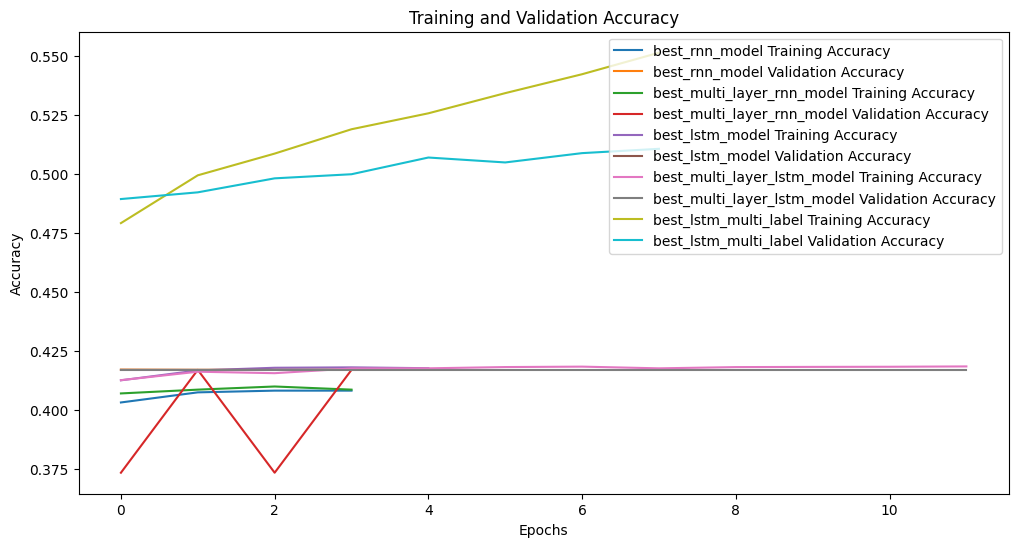

In [52]:
import pickle

# Load the results array from a file
with open('results_v1.pkl', 'rb') as file:
    loaded_results = pickle.load(file)
print("Results array loaded from 'results_v1.pkl'.")

# Verify the loaded results
print(loaded_results)



# Print test accuracies dynamically
for result in loaded_results:
    print(f"{result['model_name']} Test Accuracy: {result['test_accuracy']}")

# Plot training and validation accuracy dynamically
plt.figure(figsize=(12, 6))
for result in loaded_results:
    model_name = result['model_name']
    history = result['model_history']
    plt.plot(history.history['accuracy'], label=f'{model_name} Training Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Results array loaded from 'results_v1.pkl'.
best_rnn_model Test Accuracy: 0.17769375443458557, Test Loss: 3.1067161560058594
best_multi_layer_rnn_model Test Accuracy: 0.13988657295703888, Test Loss: 3.1635684967041016
best_lstm_model Test Accuracy: 0.17769375443458557, Test Loss: 3.0508804321289062
best_multi_layer_lstm_model Test Accuracy: 0.17769375443458557, Test Loss: 3.0716311931610107
best_lstm_multi_label Test Accuracy: 0.1876496523618698, Test Loss: 3.199500560760498


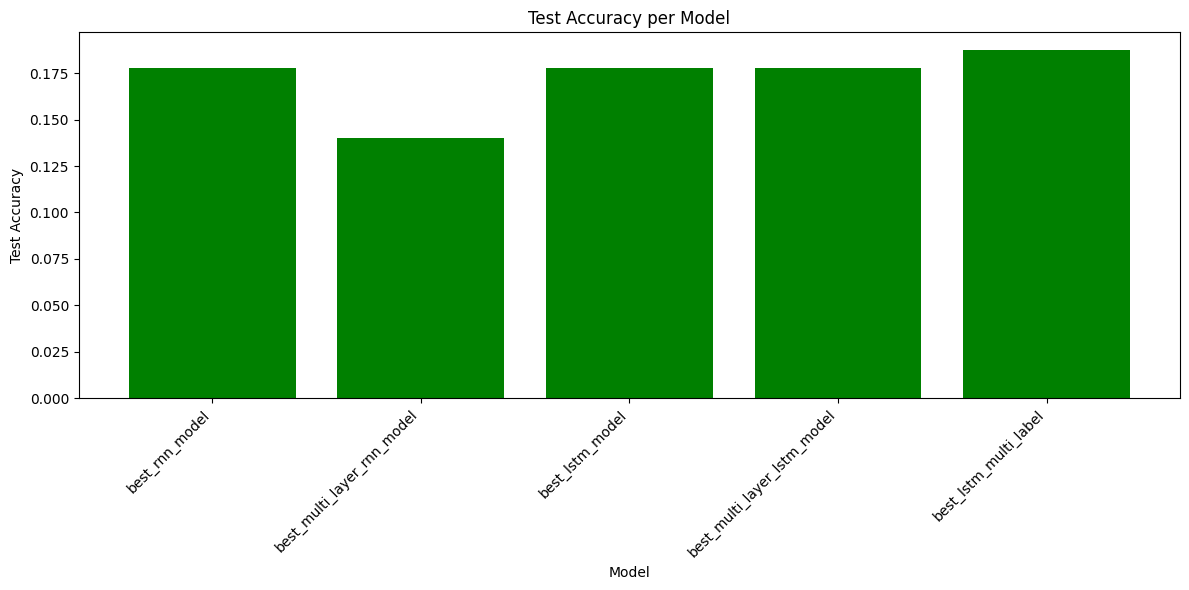

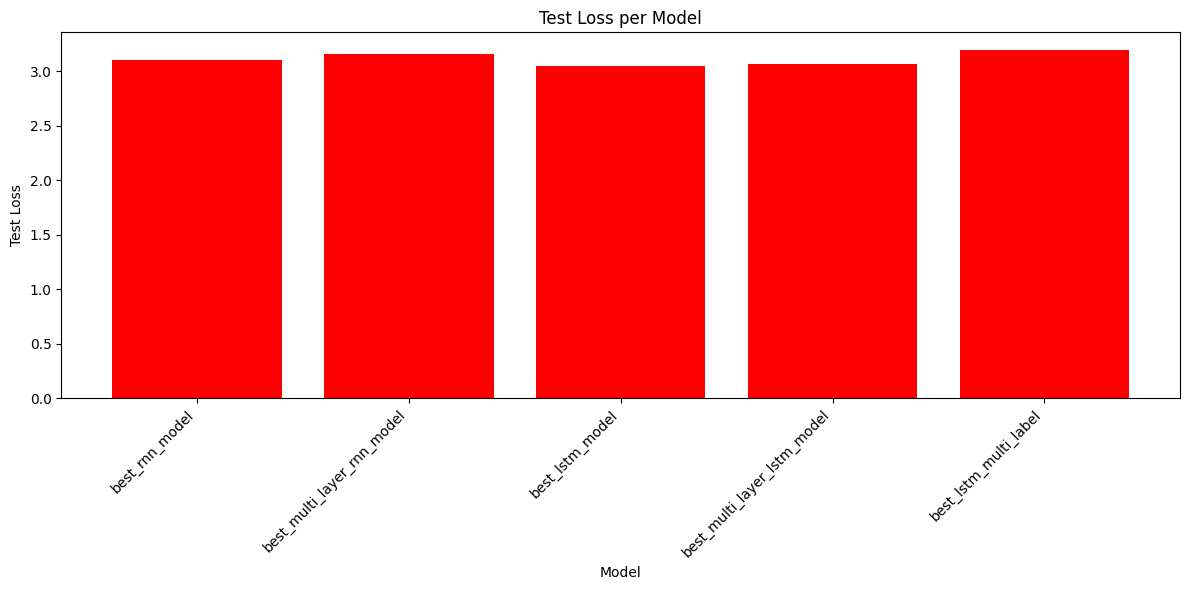

In [1]:
import pickle
import matplotlib.pyplot as plt

# Load the results array from a file
with open('results_v1.pkl', 'rb') as file:
    loaded_results = pickle.load(file)
print("Results array loaded from 'results_v1.pkl'.")

# Print test accuracies dynamically
for result in loaded_results:
    print(f"{result['model_name']} Test Accuracy: {result['test_accuracy']}, Test Loss: {result['test_loss']}")

# Prepare data for bar plots
model_names = [result['model_name'] for result in loaded_results]
test_accuracies = [result['test_accuracy'] for result in loaded_results]
test_losses = [result['test_loss'] for result in loaded_results]

# Plot Test Accuracy Bar Plot
plt.figure(figsize=(12, 6))
plt.bar(model_names, test_accuracies, color='green')
plt.title('Test Accuracy per Model')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45, ha='right')  # Rotate model names for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of x-axis labels
plt.show()

# Plot Test Loss Bar Plot
plt.figure(figsize=(12, 6))
plt.bar(model_names, test_losses, color='red')
plt.title('Test Loss per Model')
plt.xlabel('Model')
plt.ylabel('Test Loss')
plt.xticks(rotation=45, ha='right')  # Rotate model names for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of x-axis labels
plt.show()


In [ ]:
# Evaluate the models on the test set
rnn_test_loss, rnn_test_acc = rnn_model.evaluate(X_test_pad, test_df['genre'])
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_pad, test_df['genre'])
multi_layer_rnn_test_loss, multi_layer_rnn_test_acc = stacked_rnn_model.evaluate(X_test_pad, test_df['genre'])
lstm_multi_test_loss, lstm_multi_test_acc = lstm_model_multi.evaluate([X_test_pad, X_test_artist_pad], test_df['genre'])
multi_layer_lstm_test_loss, multi_layer_lstm_test_acc = multi_layer_lstm_model.evaluate(X_test_pad, test_df['genre'])


248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2837 - loss: 2.6587
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2857 - loss: 2.6571
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1734 - loss: 3.1888
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2187 - loss: 2.9095
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.2804 - loss: 2.5898


RNN Test Accuracy: 0.28015121817588806
RNN Multi Layer Test Accuracy: 0.21197228133678436
LSTM Test Accuracy: 0.2820415794849396
LSTM Multi Layer Test Accuracy: 0.28015121817588806
LSTM Multi Label Test Accuracy: 0.21902962028980255


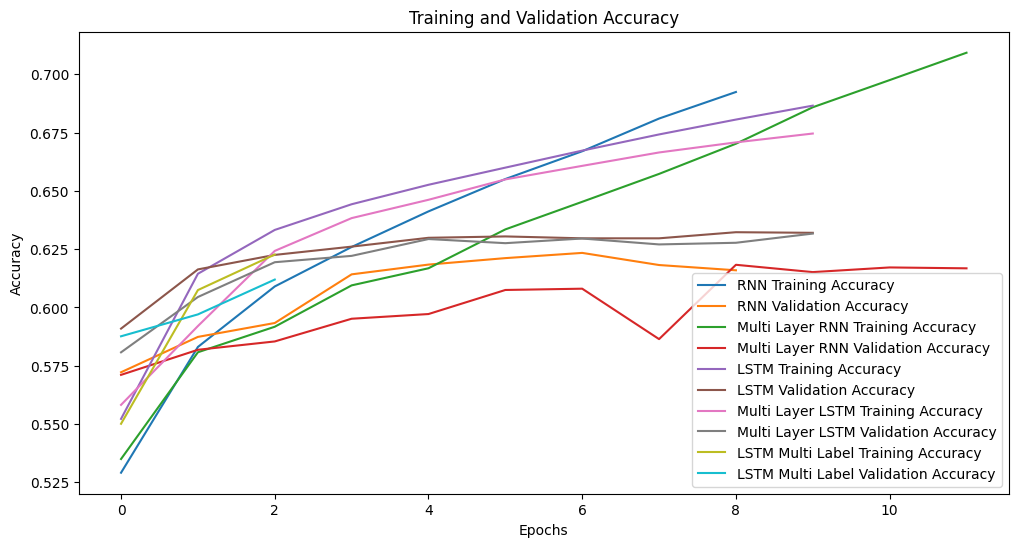

In [ ]:
# print(f"RNN Test Accuracy: {rnn_test_acc}")
# print(f"RNN Multi Layer Test Accuracy: {stacked_rnn_test_acc}")
# print(f"LSTM Test Accuracy: {lstm_test_acc}")
# print(f"LSTM Multi Layer Test Accuracy: {multi_layer_lstm_test_acc}")
# print(f"LSTM Multi Label Test Accuracy: {lstm_multi_test_acc}")


# # Plot training and validation accuracy
# plt.figure(figsize=(12, 6))
# plt.plot(history_rnn.history['accuracy'], label='RNN Training Accuracy')
# plt.plot(history_rnn.history['val_accuracy'], label='RNN Validation Accuracy')
# plt.plot(history_multi_layer_rnn.history['accuracy'], label='Multi Layer RNN Training Accuracy')
# plt.plot(history_multi_layer_rnn.history['val_accuracy'], label='Multi Layer RNN Validation Accuracy')
# plt.plot(history_lstm.history['accuracy'], label='LSTM Training Accuracy')
# plt.plot(history_lstm.history['val_accuracy'], label='LSTM Validation Accuracy')
# plt.plot(history_multi_layer_lstm.history['accuracy'], label='Multi Layer LSTM Training Accuracy')
# plt.plot(history_multi_layer_lstm.history['val_accuracy'], label='Multi Layer LSTM Validation Accuracy')
# plt.plot(history_lstm_multi.history['accuracy'], label='LSTM Multi Label Training Accuracy')
# plt.plot(history_lstm_multi.history['val_accuracy'], label='LSTM Multi Label Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [33]:
# Flatten the padded sequences to fit the classifier
X_train_flat = X_train_pad.reshape(X_train_pad.shape[0], -1)
X_val_flat = X_val_pad.reshape(X_val_pad.shape[0], -1)
X_test_flat = X_test_pad.reshape(X_test_pad.shape[0], -1)

In [34]:
# Initialize a DataFrame to store evaluation results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

In [35]:
# List of models with their names and initialized instances
models = [
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
]

# Iterate through each model, train, evaluate, and save
for idx, (model_name, model_instance) in enumerate(models):
    print(f"Training and evaluating model: {model_name}")

    # Create a pipeline (can be extended for preprocessing if needed)
    pipeline = Pipeline([
        (model_name, model_instance)
    ])
    
    # Train the pipeline on the training dataset
    pipeline.fit(X_train_flat, y_train)
    
    # Save the trained pipeline
    joblib.dump(pipeline, f'{model_name}_pipeline.pkl')
    print(f"Saved {model_name} pipeline to disk.")
    
    # Make predictions on the test dataset
    y_val_pred = pipeline.predict(X_val_flat)
    
    # Calculate evaluation metrics
    # Evaluate the model on the validation set
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, average='weighted')
    recall = recall_score(y_val, y_val_pred, average='weighted')
    f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    # Add results to the DataFrame using .loc
    results_df.loc[idx] = [model_name, accuracy, precision, recall, f1]

    # Display predictions (optional, can be removed for large datasets)
    print(f"Predictions for {model_name}: {y_val_pred}\n")

    # Predict on the test set
    y_test_pred = pipeline.predict(X_test_flat)

    # Evaluate the model on the test set
    test_accuracy = accuracy_score(test_df['genre'], y_test_pred)
    test_precision = precision_score(test_df['genre'], y_test_pred, average='weighted')
    test_recall = recall_score(test_df['genre'], y_test_pred, average='weighted')
    test_f1 = f1_score(test_df['genre'], y_test_pred, average='weighted')

    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Precision: {test_precision}")
    print(f"Test Recall: {test_recall}")
    print(f"Test F1 Score: {test_f1}")

# Display all results in a structured format
print("Evaluation Results:")
print(results_df)

# Save results to a CSV file for future reference
results_df.to_csv("model_evaluation_results.csv", index=False)
print("Saved evaluation results to 'model_evaluation_results.csv'.")


Training and evaluating model: Random Forest
Saved Random Forest pipeline to disk.
Predictions for Random Forest: [9 7 7 ... 7 7 9]

Test Accuracy: 0.22986767485822307
Test Precision: 0.557919057839331
Test Recall: 0.22986767485822307
Test F1 Score: 0.1526985727312016
Evaluation Results:
           Model  Accuracy  Precision    Recall  F1-Score
0  Random Forest  0.591918   0.612276  0.591918  0.562774
Saved evaluation results to 'model_evaluation_results.csv'.
